# Forecasting Copper Demand

The below is an illustration of some of the thoughts and processes of trying to forecast demand for copper, including an explanation of decision making and detailing of data diagnostics & preparation, pre-processing and modelling before evaluating.

When actually forecasting demand for use in a business context there may well be additional steps taken depending on time constraints and/or required accuracy. These steps will be clarified in these instances.

---

## Task

Having an up-to-date, timely indicator of copper demand can be particularly useful for decision making/risk management purposes.

Though there are no universally accepted copper demand series, commodity consultant Wood Mackenzie’s (WM) refined copper demand numbers are well-respected. Updates are dependent upon the release of their reports and it’s not always clear how quickly the latest updates are factored in to their own forecasts, how those forecasts have evolved, as well as how the forecasts themselves have been implemented.

Demand forecasts can be generated from historical demand data and optionally supplemented with exogenous variables. Updates to these variables can be used to supplement overall demand expectations where they occur prior to the release of demand data.

This project has the potential to be extremely large in complexity, with more tests, parameter tuning and variable additions. To avoid getting overly bogged down in every single detail, there won't be a comment for each line of code, decision inclusion/exclusion etc. The below should serve as a great illustration of how the task might be approached and useful business takeaways acheived.

---

## Defining Underlying Demand

The WM data we have is yearly (providing data from 1976-2040). We do however have a public monthly indicator for copper demand from the ICSG (data from Aug 2004 to April 2019) which is available through Wind. ICSG data is also split into 10 countries/regions on a monthly basis as well, which would be useful for more granular analyses. ICSG public data has a delay of around three months.

Seasonality of ICSG can therefore be applied to WM data. We could just use ICSG data directly of course, but WM tends to be more widely recognised. In a more detailed project, we might investigate differences in WM and ICSG demand accounting as well.

We could either apply overall seasonal trends to each year or apply the percentage contribution of each month to each year. The former would likely lose too much granularity, although with the latter the limitation is that the monthly weights could highlight inaccuracies or differences in methodologies. Either way, the result would be far better than any blind interpolation and we’ll go for the latter.

Typically we'd use packages we've created to import data directly from vendor APIs or local/remote databases, but for ease we've packaged data we've loaded the data into a csv for reference.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import datetime as dt
import numpy as np

# Some forecast methods use randomness. For consistency we seed the first random number here. More later..
from numpy.random import seed
seed(8)
from tensorflow import set_random_seed
set_random_seed(8)

In [4]:
raw_data = pd.read_csv('data/demand.csv', index_col='Dates', parse_dates=True)

We'll separate out the Yearly WM data and the Monthly ICSG data from the DataFrame and apply the seasonal trends of the latter to the former to create a monthly WM series.

As we know ICSG monthly data doesnt go back as far, we'll use the start date from that series. For training and testing we’ll use data up to 2018 under the assumption that they include no or few forecast elements and the demand values are less likely to change meaningfully and are representative of actual demand.

In [5]:
start_date = raw_data['ICSG M'].dropna().first_valid_index() # Jan-15
end_date = dt.datetime(2018, 12, 31)
global_demand = raw_data[['WM Y', 'ICSG M']][start_date:end_date]
global_demand['ICSG M%'] = global_demand['ICSG M'] / global_demand['ICSG M'].resample('Y').sum().resample('M').last().reindex(pd.date_range(start_date, end_date)).bfill()
global_demand['WM M'] = global_demand['WM Y'].bfill() * global_demand['ICSG M%']
global_demand.index.freq = 'M'

In [6]:
global_demand.head()

,WM Y,ICSG M,ICSG M%,WM M
Dates,,,,
2005-01-31,NaN,1400.0,0.085039,1428.789759
2005-02-28,NaN,1252.0,0.076049,1277.746270
2005-03-31,NaN,1397.0,0.084857,1425.728067
2005-04-30,NaN,1361.0,0.082670,1388.987758
2005-05-31,NaN,1414.0,0.085890,1443.077656


---

## Diagnostics

Now we have a monthly global demand series from WM. Lets run some diagnostic tests to understand the structure of the data a little better.

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [8]:
sd_result = seasonal_decompose(global_demand['WM M'], model='add')

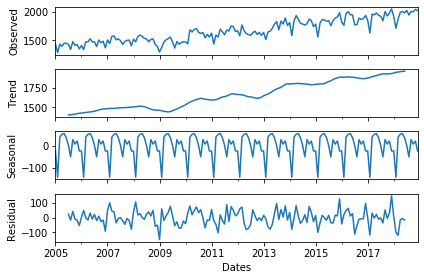

In [9]:
sd_result.plot();

It's clear this data is not stationary, so no need to do an Augmented Dickey-Fuller test at this stage. Clear trend and seasonality elements to the historical series. Lets plot out a quick seasonal chart of the last few years for clarity..

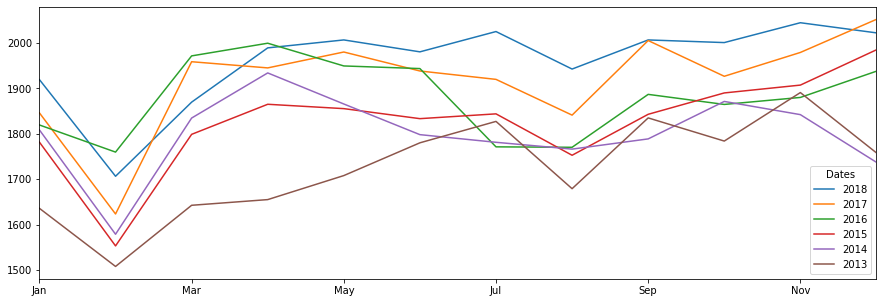

In [10]:
raw_seas_data = global_demand[['WM M']]['20130101':].reset_index(level=0)
formatted_seas_data = raw_seas_data.set_index([raw_seas_data['Dates'].dt.month, raw_seas_data['Dates'].dt.year])['WM M'].unstack()
formatted_seas_data = formatted_seas_data.iloc[:, ::-1]
formatted_seas_data.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
formatted_seas_data.plot(figsize=(15,5))

Here we can clearly see the seasonal element of the data. 2014-2018 have a particularly tight pattern. Also appears to be more of an 'additive' than 'multiplicative' seasonal relationship (we used additive in the seasonal decompose anyhow).

---

## Forecasting (Univariate)

### Methods using historical demand data & dates without additional fundamental / macro variables

Lets assess how a collection of appropriate forecasting methods work directly for assessing 2018 demand data training on data from previous years.

It's worth bearing in mind that demand is constantly evolving and these predictions outside of training sets will naturally always be limited by this. That's not to say that these forecasts can't still be improved by adding other variables - either those that are known eg holidays or those that update with a lesser lag eg certain economic data.

On a larger project we'd take things one stage further and produce a stepwise model to assess how forecasts adjust on an iterative basis. This takes considerably more time (given models are run with every data update), but allows a fuller assessment of model performance over time. For the purposes of this notebook we'll stick with the standard train/test splits for some initial investigation.

#### SARIMA

Given the highly seasonal nature of the data, SARIMA would be a worthy starting point.

First we need to get the ideal p, d, q (and seasonal p, d, q) orders from a grid search. We might do this by running through different combinations and analysing ACF and PACF plots of order combinations with better AIC values, but strong results can also be acheived from the Pyriamid Arima package (which does exactly that on an automated basis), which we'll use in this case.

In [11]:
from pmdarima import auto_arima

In [12]:
sarima_train = global_demand['WM M'][:'20171231']
sarima_test = global_demand['WM M']['20180101':]

In [13]:
auto_arima(sarima_train, seasonal=True, m=12, suppress_warnings=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -863.232
Date:                            Thu, 12 Sep 2019   AIC                           1736.463
Time:                                    14:48:59   BIC                           1751.680
Sample:                                         0   HQIC                          1742.644
                                            - 156                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1532      0.472      0.325      0.745      -0.771       1.077
ma.L1         -0.5258      0.072     -7.263      0.000      -0.668      -0.384
ar.S.L12       0.9600      0.035     27.524      0.000       0.892       1.028
ma.S.L12      -0.6865      0.100     -6.879      0.000      -0.882      -0.491
sigma2      3715.6060    372.651      9.971      0.000    2985.223    4445.989
===================================================================================
Ljung-Box (Q):                       55.02   Jarque-Bera (JB):                 6.73
Prob(Q):                              0.06   Prob(JB):                         0.03
Heteroskedasticity (H):               2.07   Skew:                            -0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [15]:
sarimax_model = SARIMAX(sarima_train, order=(0,1,1), seasonal_order=(1,0,1,12))

In [16]:
sarima_results = sarimax_model.fit()
start = len(sarima_train)
end = len(sarima_test) + len(sarima_train) - 1
sarima_pred = sarima_results.predict(start, end, typ='levels').rename('sarima_predictions')

We've now run the SARIMA predictions using levels generated by our grid search and we can now evaluate the results. For this we'll use the root mean square error (also denominated by the mean for ref) and well as a quick visual plot.

In [17]:
from statsmodels.tools.eval_measures import rmse

In [18]:
rmse(sarima_test, sarima_pred)

73.41260589690917

In [19]:
rmse(sarima_test, sarima_pred) / sarima_test.mean()

0.037466334806768455

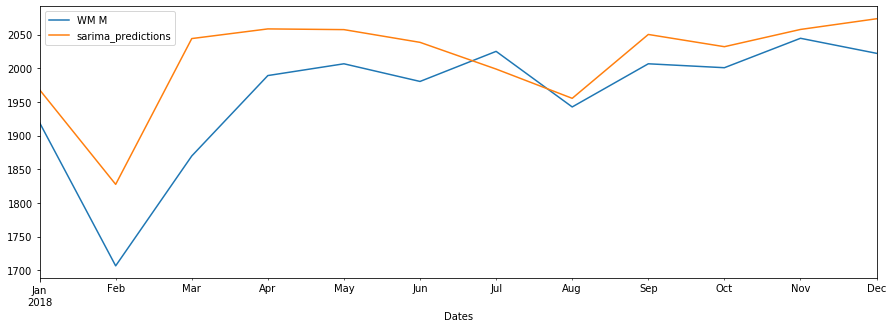

In [20]:
sarima_test.plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)

Not bad, but definite room for improvement. It's not uncommon for S&D balances to touch 73Kt so we'd certainly look to further optimise.

The model as a whole tended to overpredict - adding exogenous variables through a SARIMAX model would be worth investigating as a step to forecast improvement.

#### XGBoost

We can also investigate decision tree models as an option for forecast comparison. XGBoost has a regression algorithm we can use for use with time series.

There's no innate seasonality adjustment, but we can include a month and year column as as extra features in order to feed in these details.

In [21]:
import xgboost as xgb

In [22]:
global_demand['Month'] = global_demand.index.month
global_demand['MonthDay'] = global_demand.index.day
global_demand['Quarter'] = global_demand.index.quarter
global_demand['Year'] = global_demand.index.year
global_demand['YearDay'] = global_demand.index.dayofyear

In [23]:
xgb_xtrain = global_demand[global_demand.columns[4:]][:'20171231']
xgb_ytrain = global_demand[['WM M']][:'20171231']
xgb_xtest = global_demand[global_demand.columns[4:]]['20180101':]
xgb_ytest = global_demand[['WM M']]['20180101':]

In [24]:
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(xgb_xtrain, xgb_ytrain, verbose=False)

[14:49:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [25]:
xgb_pred = pd.Series(xgb_model.predict(xgb_xtest), xgb_ytest.index).rename('xgb_predictions')

In [26]:
rmse(xgb_ytest['WM M'], xgb_pred)

65.99094315581283

In [27]:
rmse(xgb_ytest['WM M'], xgb_pred) / xgb_ytest['WM M'].mean()

0.033678667856608585

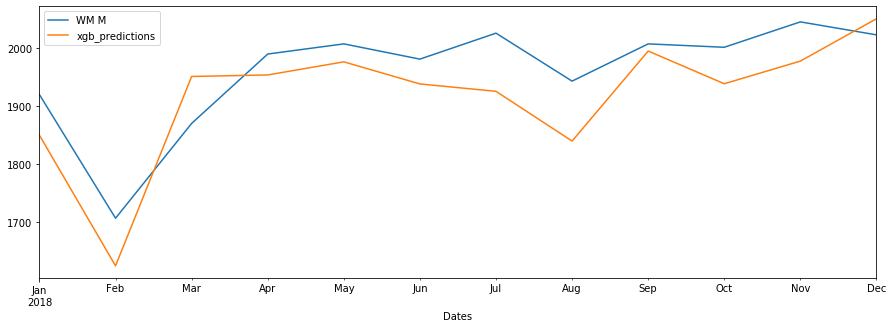

In [28]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
xgb_pred.plot(legend=True)

Interesting with the XGBoost results are that the errors are similar, but predictions have tended to underestimate on this occasion.

To improve we might look to see how much each variable added to the prediction and remove those that weren't influential. As with SARIMA, exogenous variables would be the step after, perhaps also considering lagged indicators and/or holidays (via a boolean) from major consuming nations.

#### LSTM

Long-short term memory is a recurrent neural network which can be applied to time series' in order to make forecasts. 

There's some additional pre-processing required to be as effective as possible, so we'll first scale the data then pass through keras' time series generator to produce training batches.

In [29]:
lstm_train = global_demand['WM M'][:'20171231']
lstm_test = global_demand['WM M']['20180101':]

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(lstm_train.values.reshape(-1, 1))
scaled_train = scaler.transform(lstm_train.values.reshape(-1, 1))

In [31]:
from keras.preprocessing.sequence import TimeseriesGenerator
length = 12
batch = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length, batch_size=batch)

Using TensorFlow backend.


In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [33]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, batch)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=200, verbose=0)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [34]:
test_predictions = []
first_batch = scaled_train[-length:]
current_batch = first_batch.reshape((1, length, batch))
for b in range(len(lstm_test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [35]:
lstm_pred = pd.Series(scaler.inverse_transform(test_predictions).reshape(1,12)[0], lstm_test.index).rename('lstm_predictions')

In [36]:
rmse(lstm_test, lstm_pred)

89.50771813083702

In [37]:
rmse(lstm_test, lstm_pred) / lstm_test.mean()

0.04568052168028256

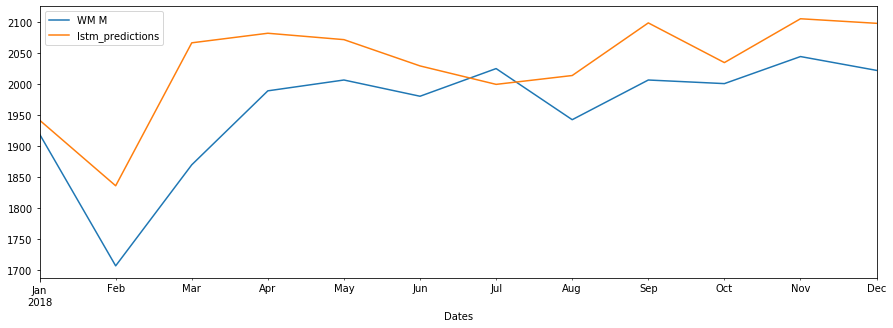

In [38]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
lstm_pred.plot(legend=True)

One point to note here is that running the above again will yeild slightly different results given neural networks use randomness by design. In a context where more stable results are required we can either seed the random number generator with a specified integer, or run the analysis multiple times and take the average. The latter is considered better, but typically takes much more time than the other methods here.

We've run the analysis a number of times (not in this notebook) and LSTM was in the range of the other models +/- 20Kt, although just one run does take considerably longer to process. We could look into reducing the number of epochs to speed up, looking into where the marinal gain from each epoch is negligible to avoid unecessary processing.

We could look at different LSTM options (such as a stacked model) or other neural network options such as a Multilayer Perceptron (MLP) architechture for example. As with other time series analysis, conducting multivariate analysis with appropriate exogenous variables would also be expected to improve forecasts.

For reference lets plot all the predictions together:

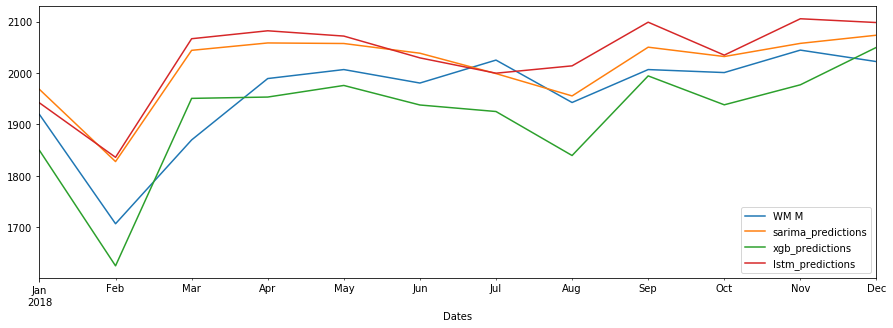

In [39]:
global_demand['WM M']['20180101':].plot(legend=True, figsize=(15,5))
sarima_pred.plot(legend=True)
xgb_pred.plot(legend=True)
lstm_pred.plot(legend=True)

The plots themselves highlight the potential usefulness of stacking different time series options, either through averaging or regression.

There are of course a number of other options for forecasting, including other related options, such as different decision tree algorithms etc, as well as options like Facebook's Prophet (or Google's Causal Impact or Uber's Edward).

---

### Identifying areas for useful additional variables

#### Fundamental
There are a number of fundamental demand layers we can highlight and data from these areas could serve to improve our analysis:

- First Use Production (% global demand)
    - Wire Rod (74%)
    - Billet (13%)
    - Cake/Slab (13%)
- End Use Production
    - Real Estate/Construction (28%)
    - Electrical Network (28%)
    - White Goods/Consumer (21%)
    - Transport/Autos (12%)
    - Machinery (11%)
- Macroeconomic
    - Industrial Production
    - PMI Surveys

#### Historical holidays
February tends to be notably lower than other months on a seasonal basis. Part of this is due to the fact that China's Spring Festival (Chinese New Year) tends to fall in February and that China are responsible for around half of global copper consumption. It can however occur in January or be spread over January and February. Including the number of Chinese holidays per month might also be a good series to investigate in order to try and capture any residual impact in Q1 particularly.

---

## Multivariate Analysis

One point of note is that global variables tend to either not exist, or be particularly delayed, so when using these additional variables, we'll very likely have to break down demand and focus on major consuming countries.

Going through the same process we can then come up with a number of separate forecasts before adding them together with a general forecast for the remainder.

That'll be for another notebook..